## Special Topics in Artificial Intelligence and Deep Learning (SCIFM0002)

### **Programming Project 2 - Dunking Biscuits in Tea**

#### Data Analysis and Discussion

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

### Reading in Data

In [65]:
dunking_df = pd.read_csv('data/dunking-data.csv')
dunking_df.head()

,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob


In [66]:
tr1 = pd.read_csv('data/tr-1.csv')
tr2 = pd.read_csv('data/tr-2.csv')
tr3 = pd.read_csv('data/tr-3.csv')

tr1.head()

,t,L,dL
0,30.000000,0.008087,0.000392
1,32.727273,0.008253,0.000270
2,35.454545,0.008607,0.000501
3,38.181818,0.008920,0.000267
4,40.909091,0.009604,0.000274


In [67]:
microscopy_df = pd.read_csv('data/microscopy-data.csv')

microscopy_df.head()

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07


### *Using a Machine Learning Algorithm to Identify Biscuit Type*

Application of a machine learning classification model is explored here. The performance of three machine learning classification algorithms are explored - random forest, gradient boosted tree and an artifical neural network.

#### Exploring & Optimising Classification Model Types

In [68]:
# setting up data for machine learning models

# identifying features and target variable (biscuit type)
X = dunking_df.drop('biscuit', axis=1)
y = dunking_df['biscuit']

# splitting into training and testing data - 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# splitting testing data further into testing and validation data - 18% testing, 12% validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4, random_state=42)


# checking categories are still balanced following split into sets (within 5% of each other)
digestive_num = y_train.value_counts()['Digestive']
rich_tea_num = y_train.value_counts()['Rich Tea']
hobnob_num = y_train.value_counts()['Hobnob']

assert abs(digestive_num - rich_tea_num) < 0.05*digestive_num
assert abs(digestive_num - hobnob_num) < 0.05*digestive_num
assert abs(rich_tea_num - hobnob_num) < 0.05*rich_tea_num

##### **Random Forest**

In [69]:
# training a RF classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)

rf.fit(X_train, y_train)
# fitting model to test data
y_pred = rf.predict(X_test)

# evaluating model using F1 score and cross-validation
overall_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Overall F1: {overall_f1:.3f}')

cv_scores = cross_val_score(rf, X, y, cv=5, scoring='f1_weighted')
print(f'Average Cross-validation F1 score: {np.mean(cv_scores):.3f}')

Overall F1: 0.785
Average Cross-validation F1 score: 0.818


##### **Gradient-Boosted Tree**

In [70]:
# training a GBT classifier
gbt = GradientBoostingClassifier(n_estimators=200, random_state=42)

gbt.fit(X_train, y_train)
y_pred = gbt.predict(X_test)

overall_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Overall F1: {overall_f1:.3f}')

cv_scores = cross_val_score(gbt, X, y, cv=5, scoring='f1_weighted')
print(f'Average Cross-validation F1 score: {np.mean(cv_scores):.3f}')

Overall F1: 0.817
Average Cross-validation F1 score: 0.826


##### **Neural Network**

In [71]:
# training a NN MLP classifier
nn = MLPClassifier(random_state=42)

nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)

overall_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Overall F1: {overall_f1:.3f}')

cv_scores = cross_val_score(nn, X, y, cv=5, scoring='f1_weighted')
print(f'Average Cross-validation F1 score: {np.mean(cv_scores):.3f}')

Overall F1: 0.267
Average Cross-validation F1 score: 0.218


Initial testing shows that the neural network is not appropriate for these data, likely as it is a relatively small and straightforward dataset. The random forest and gradient-boosted tree both perform well, but the gradient-boosted tree achieves the best F1 and cross-validation scores at this point. Therefore, the gradient-boosted tree is the choice of algorithm going forward, and will be optimised further through exploration of hyperparameter combinations in a grid search. This is done using the validation set.

##### **Optimation of Gradient-Boosted Tree**

In [72]:
'''
# defining hyperparamters to search through
param_grid = {'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['friedman_mse', 'squared_error'],
    'random_state': [42],
    'learning_rate': [0.01, 0.1, 0.001],}

# Initialize the grid search with 5-fold cross-validation
grid_search = GridSearchCV(gbt, param_grid, n_jobs=-1, cv=5, scoring='f1')

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# extracting best parameters and score
results = grid_search.best_estimator_

validation_f1 = results.score(X_val, y_val)

print(f'Validation F1 Score: {validation_f1:.3f}')
print(f'Best Parameters: {grid_search.best_params_}')
'''

"\n# defining hyperparamters to search through\nparam_grid = {'n_estimators': [50, 100, 200],\n    'max_depth': [None, 10, 20],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'max_features': ['sqrt', 'log2'],\n    'criterion': ['friedman_mse', 'squared_error'],\n    'random_state': [42],\n    'learning_rate': [0.01, 0.1, 0.001],}\n\n# Initialize the grid search with 5-fold cross-validation\ngrid_search = GridSearchCV(gbt, param_grid, n_jobs=-1, cv=5, scoring='f1')\n\n# Perform the grid search on the training data\ngrid_search.fit(X_train, y_train)\n\n# extracting best parameters and score\nresults = grid_search.best_estimator_\n\nvalidation_f1 = results.score(X_val, y_val)\n\nprint(f'Validation F1 Score: {validation_f1:.3f}')\nprint(f'Best Parameters: {grid_search.best_params_}')\n"

In [73]:
# training a GBT classifier
gbt = GradientBoostingClassifier(n_estimators=200, random_state=42, max_depth=5, learning_rate=0.5,
                                min_samples_split=2, min_samples_leaf=1, subsample=0.9, criterion='friedman_mse',
                                max_leaf_nodes=10)

gbt.fit(X_train, y_train)

# fitting model to test data
y_pred = gbt.predict(X_val)

# evaluating model using F1 score
overall_f1 = f1_score(y_val, y_pred, average='weighted')
print(f'F1 on validation set: {overall_f1:.3f}')

F1 on validation set: 0.904


In [74]:
# testing optimsed model on test data
y_pred = gbt.predict(X_test)

# evaluating model using F1 score abd cross-validation
overall_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 on testing set: {overall_f1:.3f}')

cv_scores = cross_val_score(gbt, X, y, cv=5, scoring='f1_weighted')
print(f'Average Cross-validation F1 score on testing set: {np.mean(cv_scores):.3f}')

F1 on testing set: 0.863
Average Cross-validation F1 score on testing set: 0.865


The optimisation process was able to increase the F1 score of the gradient-boosted model by approximately 5%.

#### Evaluating Individual Class Performance of Final Model

As the quoted evaluation metrics are averaged across the three classes, the performance of the optimised gradient boosted tree on the three individual classes is explored here.

In [75]:
# evaluating classifier using F1 score - obtaining values for each biscuit type
f1 = f1_score(y_test, y_pred, average=None, labels=['Digestive', 'Hobnob', 'Rich Tea'])
print(f'F1: {[f"{score:.3f}" for score in f1]}')

overall_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Overall F1: {overall_f1:.3f}')

# printing confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

F1: ['0.899', '0.801', '0.890']
Overall F1: 0.863
Predicted  Digestive  Hobnob  Rich Tea
Actual                                
Digestive        134      17         0
Hobnob            13     125        15
Rich Tea           0      17       129


In [76]:
# calculating percentage drop in F1 score between biscuit types
f1_diff = abs(f1[0] - f1[1])
f1_drop = f1_diff/f1[0] * 100
print(f'Percentage drop in F1 score from Digestive to Hobnob: {f1_drop:.2f}%')

f1_diff = abs(f1[1] - f1[2])
f1_drop = f1_diff/f1[1] * 100
print(f'Percentage drop in F1 score from Rich Tea to Hobnob: {f1_drop:.2f}%')

Percentage drop in F1 score from Digestive to Hobnob: 10.90%
Percentage drop in F1 score from Rich Tea to Hobnob: 11.03%


Results show that the model is able to accurately categorise data into biscuit type over 86% of the time. However, there is a drop in performance when considering the Hobnob data; the other two categories achive an F1 score of almost 90%, whilst hobnob is only 80%.

The behaviour of the classifier on the hobnob is explored further below by investigating what it is most commonly misclassified as.

In [77]:
# identifying what hobnobs are being most commonly misclassified as
hobnob_matrix = confusion_matrix.loc['Hobnob']
hobnob_matrix = hobnob_matrix.drop('Hobnob')
max_value = hobnob_matrix.max()
hobnob_matrix = (hobnob_matrix / hobnob_matrix.sum())*100

print(f'Hobnobs are most commonly misclassified as: {hobnob_matrix.idxmax()}. {hobnob_matrix.max():.1f}% (n={max_value}) of Hobnob false positives are this biscuit type.')

Hobnobs are most commonly misclassified as: Rich Tea. 53.6% (n=15) of Hobnob false positives are this biscuit type.


In [78]:
# exploring to see if this is reciprocated
rich_tea_matrix = confusion_matrix.loc['Rich Tea']
rich_tea_matrix = rich_tea_matrix.drop('Rich Tea')
max_value = rich_tea_matrix.max()
rich_tea_matrix = (rich_tea_matrix / rich_tea_matrix.sum())*100


print(f'Rich Teas are most commonly misclassified as: {rich_tea_matrix.idxmax()}. {rich_tea_matrix.max():.1f}% (n={max_value}) of Rich Tea false positives are this biscuit type.')

Rich Teas are most commonly misclassified as: Hobnob. 100.0% (n=17) of Rich Tea false positives are this biscuit type.


These results show that while the algorithm shows significant potential for classification of biscuit type because of its high F1 and cross-validation scores, it struggles most with distinguishing hobnobs and rich teas. This is likely because their distributions are most similar and digestive is distinguishable from both, as shown in the boxplot of *L* in the exploratory data analysis (see **exploring_data.ipynb**).

### *Exploring Pore Radius Using Microscopy Dataset*

Pore radius is provided within the microscopy dataset. The difference between the three biscuit types are explored below.

To explore trends in pore radius across the three biscuit types, the dataset must first be split into the three classes. For this, two approachs will be employed and compared; the optimised gradient-boosted classifier previously created, and k-means clustering, an unsupervised learning method.

##### **Gradient-Boosted Classifier**

In [79]:
# applying model to microscopy data
X_microscopy = microscopy_df.drop('r', axis=1)
y_microscopy = gbt.predict(X_microscopy)

microscopy_df['gbt_classification'] = y_microscopy

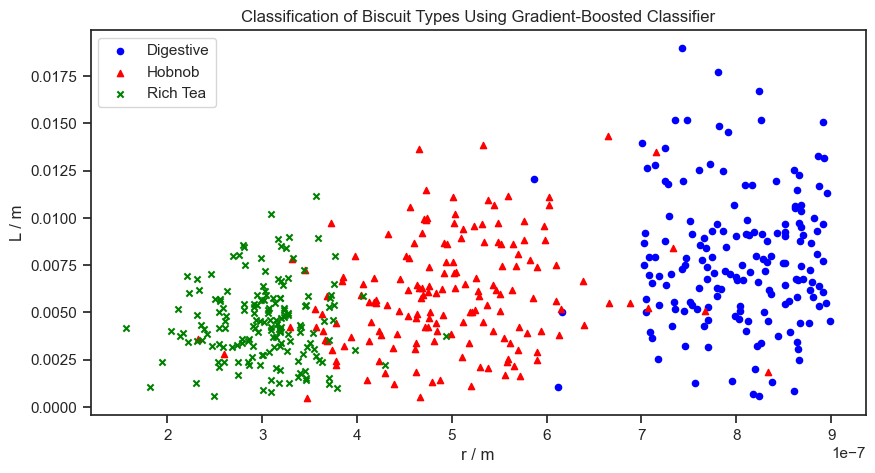

In [80]:
# plotting results - scatter plot of r vs L
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style='ticks', font='Arial')

ax.scatter(microscopy_df[microscopy_df['gbt_classification'] == 'Digestive']['r'], 
           microscopy_df[microscopy_df['gbt_classification'] == 'Digestive']['L'], label='Digestive', color='blue', marker='o', s=20)

ax.scatter(microscopy_df[microscopy_df['gbt_classification'] == 'Hobnob']['r'],
           microscopy_df[microscopy_df['gbt_classification'] == 'Hobnob']['L'], label='Hobnob', color='red', marker='^', s=20)

ax.scatter(microscopy_df[microscopy_df['gbt_classification'] == 'Rich Tea']['r'],
           microscopy_df[microscopy_df['gbt_classification'] == 'Rich Tea']['L'], label='Rich Tea', color='green', marker='x', s=20)

ax.set_xlabel('r / m')
ax.set_ylabel('L / m')
ax.set_title('Classification of Biscuit Types Using Gradient-Boosted Classifier')
ax.legend()

The above plot shows that the classifier has classified the data and created three distinct clusters of *r*, which is to be expected; all biscuits of the same type will have very similar *r* values, given their same ingredients and manufacture process. 

However, there are a few anomalies. There is not a clear margin between hobnobs and rich teas, as expected given the outcomes of the earlier individual class performance analysis, and there are some lying in what might be considered to be the "wrong" cluster. There are also a number of hobnobs within what appears to be the digestive cluster. 

##### **K-Means Clustering**

K-means clustering is an unsupervised machine learning method, meaning it is applied to data without a "true" value. Whilst we have an idea on clusters having explored the pore radius distributions, this technique is applied as it is commonly applied to problems of this type and is therefore reliable.

Whilst three clusters are expected, this is validated further by creating elbow and silhouette score plots.

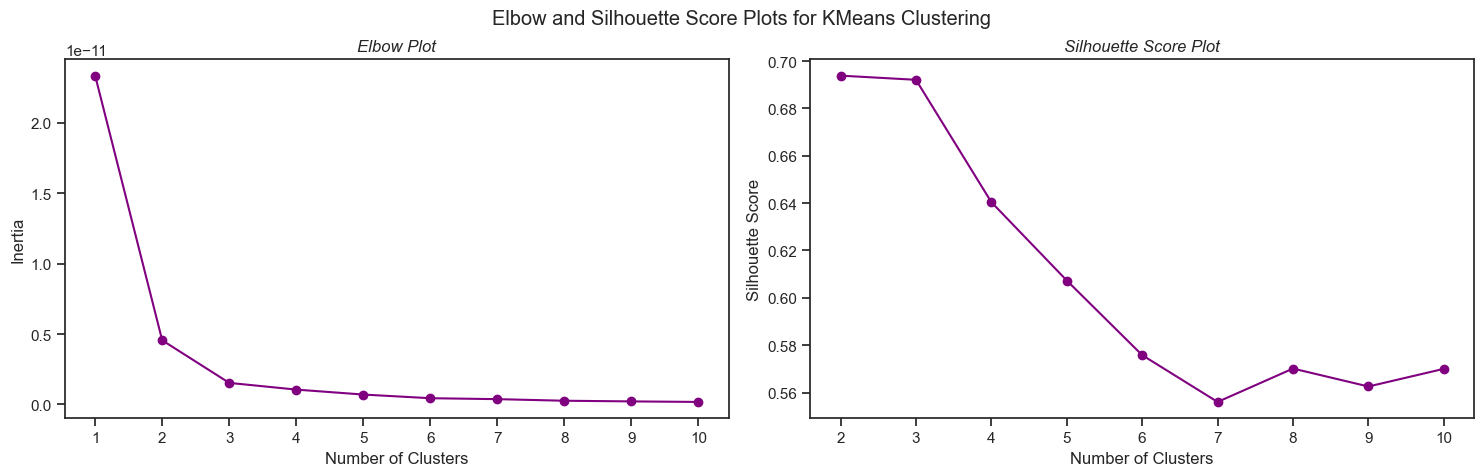

In [81]:
# creating elbow and silhouette score plots to check number of clusters

# elbow plot
inertia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(microscopy_df[['r']])
    inertia.append(kmeans.inertia_)

# silhouette score
silhouette = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(microscopy_df[['r']])
    silhouette.append(silhouette_score(microscopy_df[['r']], kmeans.labels_))


# plotting
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.set_theme(style='ticks', font='Arial')

axes[0].plot(range(1, 11), inertia, marker='o', color='purple')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Plot', fontstyle='italic')
axes[0].set_xticks(range(1, 11))

axes[1].plot(range(2, 11), silhouette, marker='o', color='purple')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score Plot', fontstyle='italic')
axes[1].set_xticks(range(2, 11))

fig.suptitle('Elbow and Silhouette Score Plots for KMeans Clustering', y=0.95)
fig.tight_layout()

The elbow plot appears to have its elbow at 3, whilst the silhouette score plot has a peak at 3. Therefore, this is the correct number of clusters for the given data. This was expected given the three distinct biscuit types.

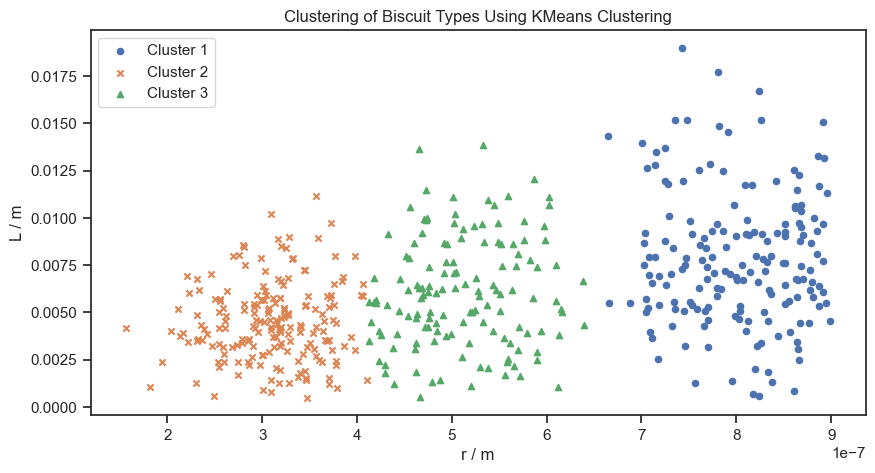

In [82]:
# fitting KMeans clustering model to data
k_means = KMeans(n_clusters=3, random_state=42)
k_means.fit(microscopy_df[['r']])
microscopy_df['kmeans_labels'] = k_means.labels_

# plotting results - scatter plot of r vs L
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style='ticks', font='Arial')

ax.scatter(microscopy_df[microscopy_df['kmeans_labels'] == 0]['r'], 
           microscopy_df[microscopy_df['kmeans_labels'] == 0]['L'], label='Cluster 1', marker='o', s=20)

ax.scatter(microscopy_df[microscopy_df['kmeans_labels'] == 1]['r'],
           microscopy_df[microscopy_df['kmeans_labels'] == 1]['L'], label='Cluster 2', marker='x', s=20)

ax.scatter(microscopy_df[microscopy_df['kmeans_labels'] == 2]['r'],
           microscopy_df[microscopy_df['kmeans_labels'] == 2]['L'], label='Cluster 3', marker='^', s=20)

ax.set_xlabel('r / m')
ax.set_ylabel('L / m')
ax.set_title('Clustering of Biscuit Types Using KMeans Clustering')
ax.legend()

The k-means approach has produced three clear clusters, with no overlap. The clusters are very similar to those obtained from the gradient boosted classification method, which adds confidence to these predictions.

##### **Comparison of Approaches**

As there is no ground truth, the decision is made to only classify points as the given biscuit if both of the above approaches classify them as such. The corroboration of the two methods are explored below.

Having analysed the above data, the assumption is made that *0* corresponds to digestive, *1* to rich tea and *2* to hobnob; the gradient-boosted classifier is thought to be mostly right given the previously obtained F1 and cross-validation scores.

In [83]:
microscopy_df.head()

,gamma,phi,eta,L,t,r,gbt_classification,kmeans_labels
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07,Digestive,0
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07,Rich Tea,1
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07,Hobnob,1
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07,Digestive,0
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07,Digestive,0


In [84]:
# looping through datapoints and checking the corroboration between classification methods - dropping datapoints that do not agree
dropped_rows = 0
length = len(microscopy_df)

for index, row in microscopy_df.iterrows():
    if row['gbt_classification'] == 'Digestive' and row['kmeans_labels'] != 0:
        microscopy_df.drop(index, inplace=True)
        dropped_rows += 1

    if row['gbt_classification'] == 'Rich Tea' and row['kmeans_labels'] != 1:
        microscopy_df.drop(index, inplace=True)
        dropped_rows += 1

    if row['gbt_classification'] == 'Hobnob' and row['kmeans_labels'] != 2:
        microscopy_df.drop(index, inplace=True)
        dropped_rows += 1
        
percentage_dropped = (dropped_rows / length) * 100
print(f'Dropped {dropped_rows} rows ({percentage_dropped:.2f}% of dataset).')

Dropped 39 rows (7.80% of dataset).


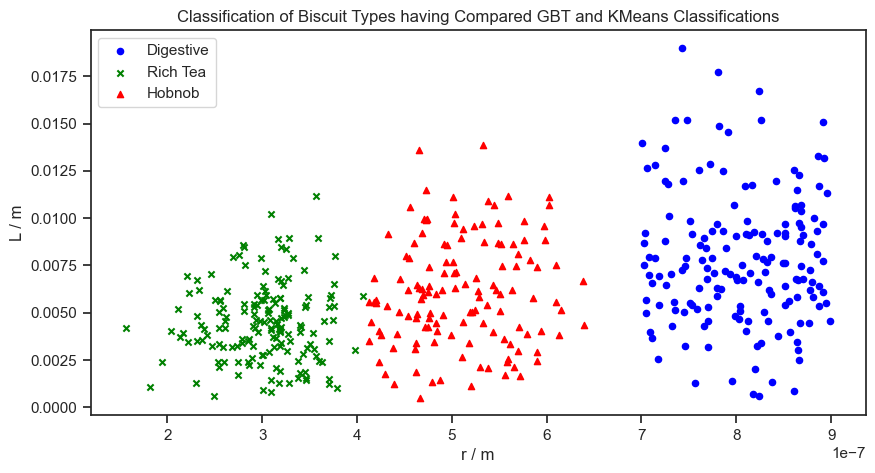

In [85]:
# plotting results - scatter plot of r vs L
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style='ticks', font='Arial')

# plotting biscuit types individually to change colour and marker style
ax.scatter(microscopy_df[microscopy_df['gbt_classification'] == 'Digestive']['r'], 
           microscopy_df[microscopy_df['gbt_classification'] == 'Digestive']['L'], label='Digestive', color='blue', marker='o', s=20)

ax.scatter(microscopy_df[microscopy_df['gbt_classification'] == 'Rich Tea']['r'], 
           microscopy_df[microscopy_df['gbt_classification'] == 'Rich Tea']['L'], label='Rich Tea', color='green', marker='x', s=20)

ax.scatter(microscopy_df[microscopy_df['gbt_classification'] == 'Hobnob']['r'], 
           microscopy_df[microscopy_df['gbt_classification'] == 'Hobnob']['L'], label='Hobnob', color='red', marker='^', s=20)

ax.set_xlabel('r / m')
ax.set_ylabel('L / m')
ax.set_title('Classification of Biscuit Types having Compared GBT and KMeans Classifications')
ax.legend()


The above plot shows that the comparison of the two approaches gives three distinct clusters, with minimal overlap between biscuit types - it is much cleaner. Whilst data were removed from the data, it corresponded to only 7.80% and so is not a significant portion. The removal significantly increases confidence in the classification, justifying the removal of data.

##### **Calculating and Comparing Average Pore Radius**

The dataset that contains only data classified the same way by both the created gradient-boosted classifier and k-means will be used to calculated an average pore radius for each biscuit.

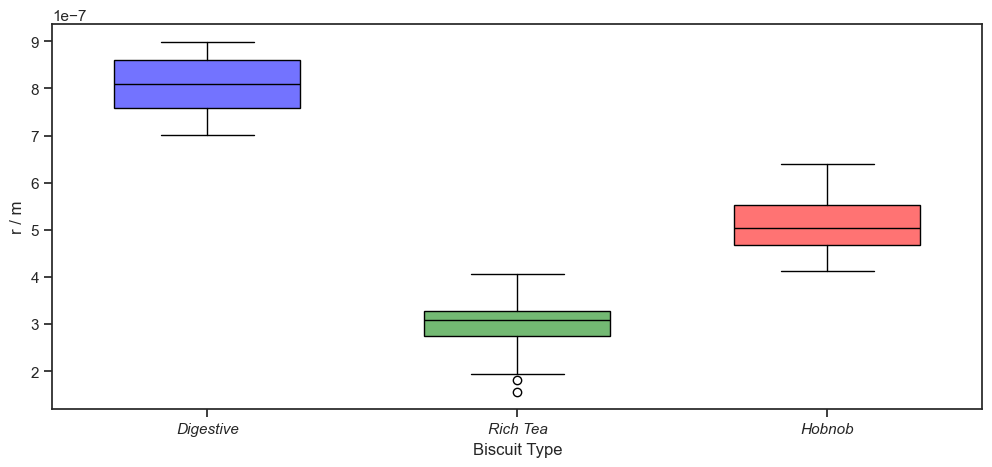

In [23]:
# box plot showing r distribution for each biscuit type
fig, ax = plt.subplots(figsize=(12, 5))
sns.set_theme(style='ticks', font='Arial')

boxes = [
    microscopy_df[microscopy_df['gbt_classification'] == 'Digestive']['r'],
    microscopy_df[microscopy_df['gbt_classification'] == 'Rich Tea']['r'],
    microscopy_df[microscopy_df['gbt_classification'] == 'Hobnob']['r']
]

box_colors = [(0, 0, 1, 0.55),  # blue for digestive
              (0, 0.5, 0, 0.55),  # green for rich tea
              (1, 0, 0, 0.55)]  # red for hobnob


boxplot = ax.boxplot(boxes, positions=[1, 2, 3], patch_artist=True, widths=0.6)

for patch, color in zip(boxplot['boxes'], box_colors):
    patch.set_facecolor(color)


# setting median line to black for easier visualisation
for median in boxplot['medians']:
    median.set(color='black', linewidth=1)


ax.set_xlabel('Biscuit Type')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Digestive', 'Rich Tea', 'Hobnob'], fontstyle='italic')

ax.set_ylabel('r / m')
# ax.set_title('Distribution of r for Each Biscuit Type')
plt.show()

In [24]:
# finding average r for each biscuit type
digestive_df = microscopy_df[microscopy_df['gbt_classification'] == 'Digestive']
rich_tea_df = microscopy_df[microscopy_df['gbt_classification'] == 'Rich Tea']
hobnob_df = microscopy_df[microscopy_df['gbt_classification'] == 'Hobnob']

# finding an average r
digestive_r = digestive_df['r'].mean()
rich_tea_r = rich_tea_df['r'].mean()
hobnob_r = hobnob_df['r'].mean()

# finding standard deviation of r
digestive_r_std = digestive_df['r'].std()
rich_tea_r_std = rich_tea_df['r'].std()
hobnob_r_std = hobnob_df['r'].std()

print(f'Average r for Digestive: {digestive_r:.3g} m')
print(f'Standard deviation of r for Digestive: {digestive_r_std:.3g} m')
print(f'Average r for Rich Tea: {rich_tea_r:.3g} m')
print(f'Standard deviation of r for Rich Tea: {rich_tea_r_std:.3g} m')
print(f'Average r for Hobnob: {hobnob_r:.3g} m')
print(f'Standard deviation of r for Hobnob: {hobnob_r_std:.3g} m')

Average r for Digestive: 8.05e-07 m
Standard deviation of r for Digestive: 5.79e-08 m
Average r for Rich Tea: 3.02e-07 m
Standard deviation of r for Rich Tea: 4.54e-08 m
Average r for Hobnob: 5.1e-07 m
Standard deviation of r for Hobnob: 5.58e-08 m


The box plot shows that there is very little overlap between observed *r* values for the three biscuit types, and so there is high confidence in the classification results. An average is calculated; digestive has the largest pore radius (8.05 x 10<sup>-7</sup>m), followed by hobnob (5.10 x 10<sup>-7</sup>m) and then rich tea (3.02 x 10<sup>-7</sup>m).

| Biscuit Type | Average pore radius (m) | Standard Deviation (m) |
|--------------|---------------|---------------|
| Digestive    | 8.05 x 10<sup>-7</sup>        | 5.79 x 10<sup>-8</sup>        |
| Rich Tea     | 3.02 x 10<sup>-7</sup>        | 4.54 x 10<sup>-8</sup>        |
| Hobnob       | 5.10 x 10<sup>-7</sup>        | 5.58 x 10<sup>-8</sup>        |

### *Calculating a Capillary Flow Rate Coefficient for the Different Biscuit Types*

To find a value for capillary flow rate, the time-resolved measurement datasets can be used. Each correspond to a different biscuit type, however, exactly which one is unknown. To determine which dataset corresponds to which biscuit, pore radii are compared. An average *r* is determined for each dataset through use of the Washburn equation, and an uncertainty in this value is calculated by considering the associated uncertainty in *L*.

#### Determining *r* and Biscuit Type

##### **Dataset 1**

In [86]:
tr1['gamma'] = 6.78e-2
tr1['eta'] = 9.93e-4
tr1['phi'] = 1.45

# calculating r based on Washburn equation and calculating an uncertainty based on dL
tr1['predicted_r'] = (tr1['L']**2 * 2*tr1['eta'])/(tr1['gamma']*tr1['t']*np.cos(tr1['phi']))
tr1['dr'] = tr1['predicted_r'] * np.sqrt((tr1['dL']/tr1['L'])**2)

average_r1 = tr1['predicted_r'].mean()
numerator_uncertainty = np.sqrt((tr1['dr']**2).sum())
denominator_uncertainty = np.sqrt(len(tr1))
d_average_r1 = numerator_uncertainty / denominator_uncertainty

print(f'Average r for TR-1: {average_r1:.3g} ± {d_average_r1:.3g} m')

Average r for TR-1: 5.19e-07 ± 1.36e-08 m


##### **Dataset 2**

In [87]:
tr2['gamma'] = 6.78e-2
tr2['eta'] = 9.93e-4
tr2['phi'] = 1.45

tr2['predicted_r'] = (tr2['L']**2 * 2*tr2['eta'])/(tr2['gamma']*tr2['t']*np.cos(tr2['phi']))
tr2['dr'] = tr2['predicted_r'] * np.sqrt((tr2['dL']/tr2['L'])**2)

average_r2 = tr2['predicted_r'].mean()
numerator_uncertainty = np.sqrt((tr2['dr']**2).sum())
denominator_uncertainty = np.sqrt(len(tr2))
d_average_r2 = numerator_uncertainty / denominator_uncertainty

print(f'Average r for TR-2: {average_r2:.3g} ± {d_average_r2:.3g} m')

Average r for TR-2: 2.79e-07 ± 1.05e-08 m


##### **Dataset 3**

In [88]:
tr3['gamma'] = 6.78e-2
tr3['eta'] = 9.93e-4
tr3['phi'] = 1.45

tr3['predicted_r'] = (tr3['L']**2 * 2*tr3['eta'])/(tr3['gamma']*tr3['t']*np.cos(tr3['phi']))
tr3['dr'] = tr3['predicted_r'] * np.sqrt((tr3['dL']/tr3['L'])**2)

average_r3 = tr3['predicted_r'].mean()
numerator_uncertainty = np.sqrt((tr3['dr']**2).sum())
denominator_uncertainty = np.sqrt(len(tr3))
d_average_r3 = numerator_uncertainty / denominator_uncertainty

print(f'Average r for TR-3: {average_r3:.3g} ± {d_average_r3:.3g} m')

Average r for TR-3: 1e-06 ± 2.13e-08 m


##### **Comparison of Datasets**

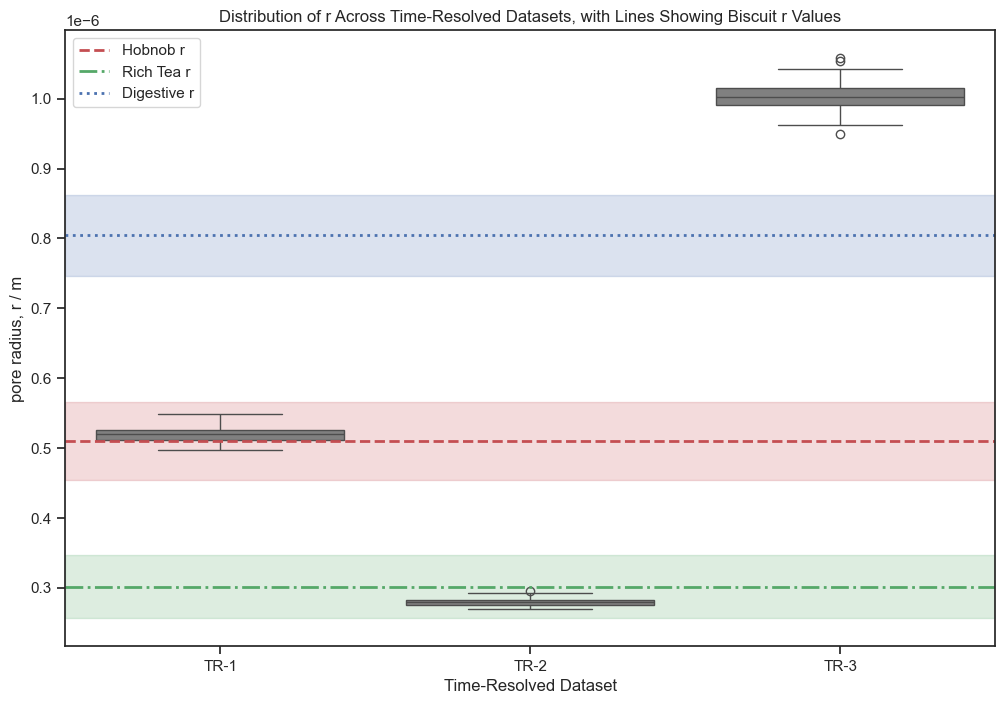

In [89]:
# boxplot showing r distribution across time-resolved trials, adding the previously determined pore radius values
tr1['tr'] = 'tr-1'
tr2['tr'] = 'tr-2'
tr3['tr'] = 'tr-3'

tr = pd.concat([tr1, tr2, tr3])

fig, ax = plt.subplots(figsize=(12, 8))
sns.set_theme(style='ticks', font='Arial')

sns.boxplot(x='tr', y='predicted_r', data=tr, color='grey')
ax.axhline(hobnob_r, color='r', linestyle='--', label='Hobnob r', linewidth=2)
ax.axhspan(hobnob_r - hobnob_r_std, hobnob_r + hobnob_r_std, color='r', alpha=0.2)

ax.axhline(rich_tea_r, color='g', linestyle='-.', label='Rich Tea r', linewidth=2)
ax.axhspan(rich_tea_r - rich_tea_r_std, rich_tea_r + rich_tea_r_std, color='g', alpha=0.2)

ax.axhline(digestive_r, color='b', linestyle=':', label='Digestive r', linewidth=2)
ax.axhspan(digestive_r - digestive_r_std, digestive_r + digestive_r_std, color='b', alpha=0.2)

ax.set_xlabel('Time-Resolved Dataset')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['TR-1', 'TR-2', 'TR-3'])
ax.set_ylabel('pore radius, r / m')
ax.set_title('Distribution of r Across Time-Resolved Datasets, with Lines Showing Biscuit r Values')

ax.legend()
plt.show()

The above box plot shows quite clearly which time-resolved dataset corresponds with each biscuit type; it appears that TR1 corresponds to hobnob, TR2 rich tea and TR3 digestive. The hobnob and rich tea calculated pore radii fit very closely with the values calculated from the time-resolved measurements and the Washburn equation. There is however a greater difference when considering the digestive data. To add confidence to this categorisation, additional plots are created below, considering the provided uncertainty in *L* and calculating the resulting *r* distribution.

In [91]:
# determining upper and lower bound of r given uncertainty in L
# TR1
tr1['minL'] = tr1['L'] - tr1['dL']
tr1['maxL'] = tr1['L'] + tr1['dL']

tr1['predicted_r_minL'] = (tr1['minL']**2 * 2*tr1['eta'])/(tr1['gamma']*tr1['t']*np.cos(tr1['phi']))
tr1['predicted_r_maxL'] = (tr1['maxL']**2 * 2*tr1['eta'])/(tr1['gamma']*tr1['t']*np.cos(tr1['phi']))

# TR2
tr2['minL'] = tr2['L'] - tr2['dL']
tr2['maxL'] = tr2['L'] + tr2['dL']

tr2['predicted_r_minL'] = (tr2['minL']**2 * 2*tr2['eta'])/(tr2['gamma']*tr2['t']*np.cos(tr2['phi']))
tr2['predicted_r_maxL'] = (tr2['maxL']**2 * 2*tr2['eta'])/(tr2['gamma']*tr2['t']*np.cos(tr2['phi']))

# TR3
tr3['minL'] = tr3['L'] - tr3['dL']
tr3['maxL'] = tr3['L'] + tr3['dL']

tr3['predicted_r_minL'] = (tr3['minL']**2 * 2*tr3['eta'])/(tr3['gamma']*tr3['t']*np.cos(tr3['phi']))
tr3['predicted_r_maxL'] = (tr3['maxL']**2 * 2*tr3['eta'])/(tr3['gamma']*tr3['t']*np.cos(tr3['phi']))

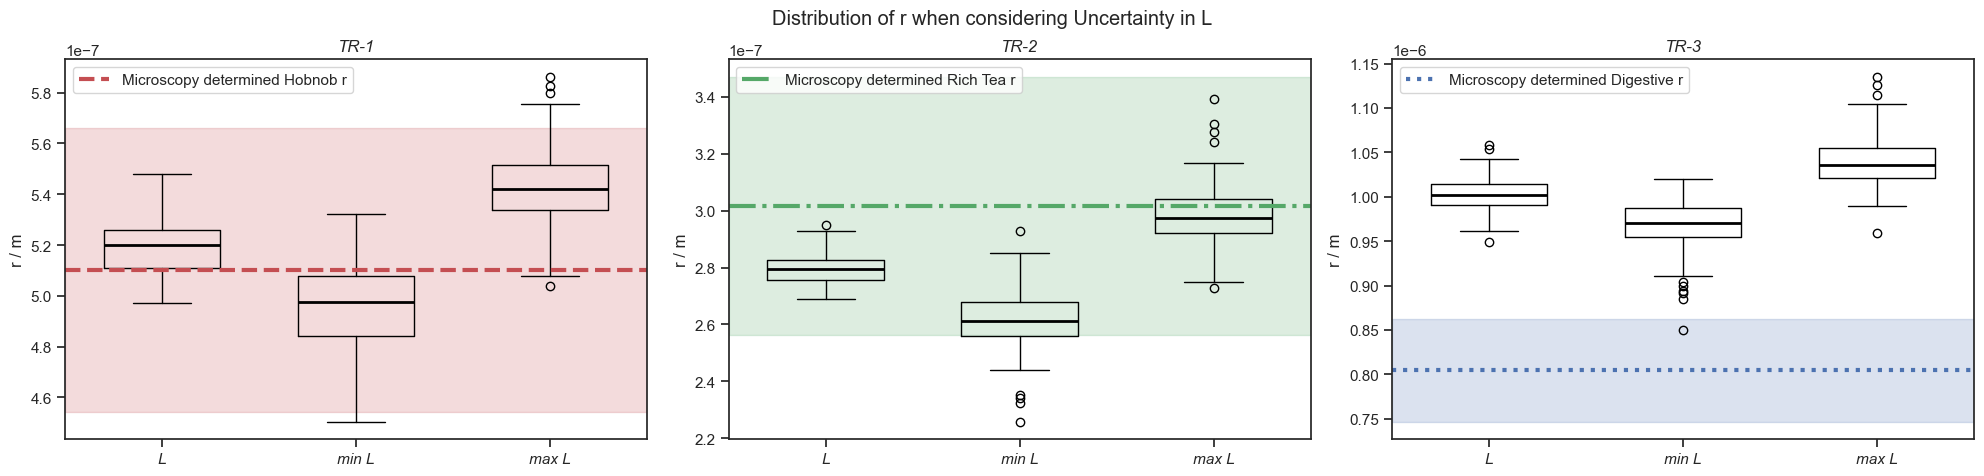

In [92]:
# plotting box plots for upper and lower bound r distributions based on uncertainty in L
fig, axes = plt.subplots(1,3,figsize=(20, 5))
sns.set_theme(style='ticks', font='Arial')
medianprops = dict(linewidth=2, color='black')

# TR1

axes[0].boxplot([tr1['predicted_r'], tr1['predicted_r_minL'], tr1['predicted_r_maxL']], positions=[1,2,3], 
           widths=0.6, medianprops=medianprops,)
axes[0].hlines(hobnob_r, 0.5, 3.5, color='r', linestyle='--', label='Microscopy determined Hobnob r', linewidth=3)
axes[0].axhspan(hobnob_r - hobnob_r_std, hobnob_r + hobnob_r_std, color='r', alpha=0.2)

axes[0].set_title('TR-1', fontstyle='italic')

# TR2
axes[1].boxplot([tr2['predicted_r'], tr2['predicted_r_minL'], tr2['predicted_r_maxL']], positions=[1,2,3], 
           widths=0.6, medianprops=medianprops,)
axes[1].hlines(rich_tea_r, 0.5, 3.5, color='g', linestyle='-.', label='Microscopy determined Rich Tea r', linewidth=3)
axes[1].axhspan(rich_tea_r - rich_tea_r_std, rich_tea_r + rich_tea_r_std, color='g', alpha=0.2)

axes[1].set_title('TR-2', fontstyle='italic')

# TR3
axes[2].boxplot([tr3['predicted_r'], tr3['predicted_r_minL'], tr3['predicted_r_maxL']], positions=[1,2,3], 
           widths=0.6, medianprops=medianprops,)
axes[2].hlines(digestive_r, 0.5, 3.5, color='b', linestyle=':', label='Microscopy determined Digestive r', linewidth=3)
axes[2].axhspan(digestive_r - digestive_r_std, digestive_r + digestive_r_std, color='b', alpha=0.2)

axes[2].set_title('TR-3', fontstyle='italic')


for ax in axes:
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['L', 'min L', 'max L'], fontstyle='italic')
    ax.set_ylabel('r / m')
    ax.legend(loc='upper left')


fig.suptitle('Distribution of r when considering Uncertainty in L', y=0.95)
fig.tight_layout()

These plots show that the uncertainty in *L* should be considered, as in the case of the rich tea and digestive, the distributions resulting from the upper and lower band values of *L*, respectively, lie closer to the results obtained from microscopy. Therefore, these distributions and resulting values will be the ones used going forward.

There is still a significant difference in the case of the digestive (20.3%) between the resulting distribution and the microscopy data. This may be as a result of limitations of the Washburn equations; this is explored later.

In [93]:
# calculating percentage difference between calcualted pore radius and average pore radius for each trial
average_r1 = tr1['predicted_r'].mean()
average_r2 = tr2['predicted_r_maxL'].mean()
average_r3 = tr3['predicted_r_minL'].mean()


percentage_difference1 = (abs(average_r1 - hobnob_r) / hobnob_r) * 100
percentage_difference2 = (abs(average_r2 - rich_tea_r) / rich_tea_r) * 100
percentage_difference3 = (abs(average_r3 - digestive_r) / digestive_r) * 100

print(f'Percentage difference between calculated and average r for TR-1: {percentage_difference1:.2f}%')
print(f'Percentage difference between calculated and average r for TR-2: {percentage_difference2:.2f}%')
print(f'Percentage difference between calculated and average r for TR-3: {percentage_difference3:.1f}%')

Percentage difference between calculated and average r for TR-1: 1.74%
Percentage difference between calculated and average r for TR-2: 1.03%
Percentage difference between calculated and average r for TR-3: 20.3%


In [94]:
print(f'TR-1 average pore radius: {average_r1:.3g} m')
print(f'TR-2 average pore radius: {average_r2:.3g} m')
print(f'TR-3 average pore radius: {average_r3:.3g} m')

TR-1 average pore radius: 5.19e-07 m
TR-2 average pore radius: 2.99e-07 m
TR-3 average pore radius: 9.68e-07 m


#### Calculating Rate of Capillary Flow & Exploring the Washburn Relationship

A value for rate of capillary flow for each of the biscuit types can be established by considering the time-resolved datasets and the change of *L* over time. Correlation between L and t are explored, as well as the fit of the Washburn equation; it states that *L<sup>2</sup>* is proportional to *t*, and so if the equation fits, then this will be very highly correlated.

##### **Hobnob - TR1**

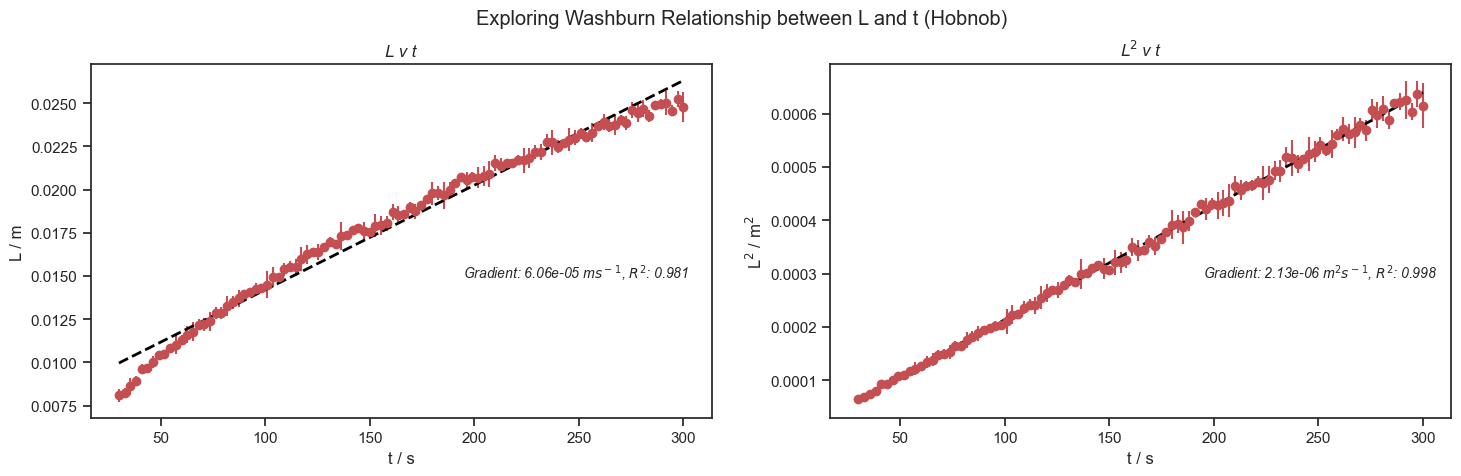

In [95]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
sns.set_theme(style='ticks', font='Arial')

# plotting L against t for entire time period
sns.scatterplot(data=tr1, x='t', y='L', ax=axes[0])
axes[0].errorbar(tr1['t'], tr1['L'], yerr=tr1['dL'], fmt='o', label='TR-1', c='r')

# adding line of best fit and determining gradient
m, c = np.polyfit(tr1['t'], tr1['L'], 1)
axes[0].plot(tr1['t'], m*tr1['t'] + c, color='black', linewidth=2, linestyle='--')

# determining R^2
residuals = tr1['L'] - (m*tr1['t'] + c)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((tr1['L'] - np.mean(tr1['L']))**2)
r_squared = 1 - (ss_res / ss_tot)

axes[0].text(0.6, 0.4, f'Gradient: {m:.3g} m$s^-$$^1$, $R^2$: {r_squared:.3f}', transform=axes[0].transAxes, fontsize=10, fontstyle='italic')
axes[0].set_title('L v t', fontstyle='italic')
axes[0].set_ylabel('L / m')


# plotting L^2 against t, adding error bars (dL)
tr1['L^2'] = tr1['L']**2
sns.scatterplot(data=tr1, x='t', y='L^2', ax=axes[1])
axes[1].errorbar(tr1['t'], tr1['L^2'], yerr=2*tr1['L']*tr1['dL'], fmt='o', label='TR-1', c='r')

m, c = np.polyfit(tr1['t'], tr1['L^2'], 1)
axes[1].plot(tr1['t'], m*tr1['t'] + c, color='black', linewidth=2, linestyle='--')
hobnob_rate = m

residuals = tr1['L^2'] - (m*tr1['t'] + c)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((tr1['L^2'] - np.mean(tr1['L^2']))**2)
r_squared = 1 - (ss_res / ss_tot)

axes[1].text(0.6, 0.4, f'Gradient: {m:.3g} m$^2$$s^-$$^1$, $R^2$: {r_squared:.3f}', transform=axes[1].transAxes, fontsize=10, fontstyle='italic')
axes[1].set_title('L$^2$ v t', fontstyle='italic')
axes[1].set_ylabel('L$^2$ / m$^2$')


for ax in axes:
    ax.set_xlabel('t / s')

fig.suptitle('Exploring Washburn Relationship between L and t (Hobnob)', y=0.95)
fig.tight_layout()


##### **Rich Tea - TR2**

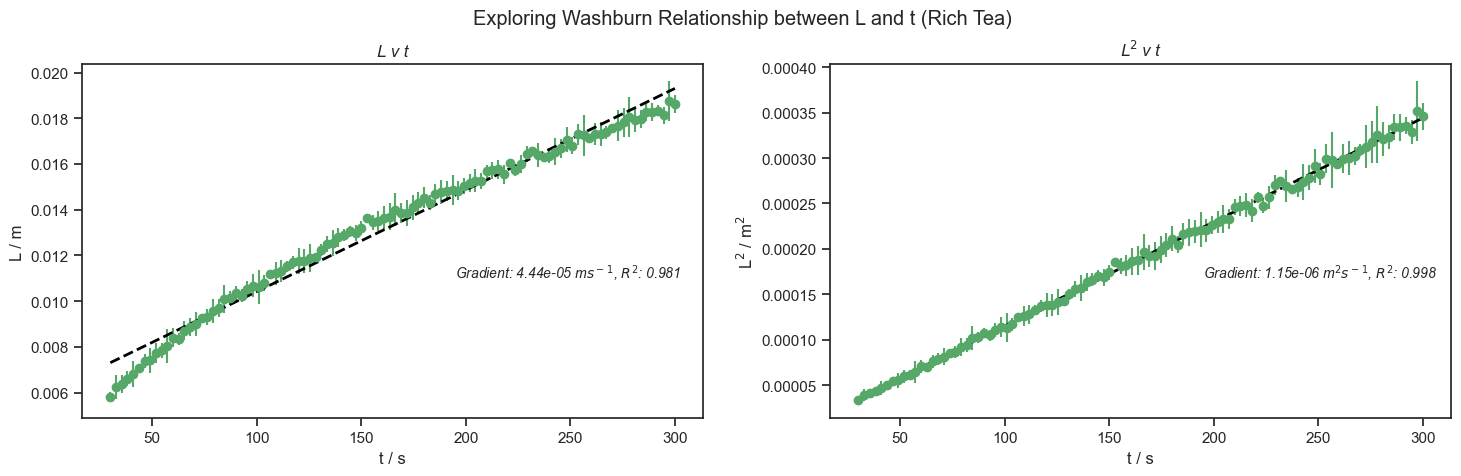

In [96]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
sns.set_theme(style='ticks', font='Arial')

# plotting L against t for entire time period
sns.scatterplot(data=tr2, x='t', y='L', ax=axes[0])
axes[0].errorbar(tr2['t'], tr2['L'], yerr=tr2['dL'], fmt='o', label='TR-2', c='g')

# adding line of best fit and determining gradient
m, c = np.polyfit(tr2['t'], tr2['L'], 1)
axes[0].plot(tr2['t'], m*tr2['t'] + c, color='black', linewidth=2, linestyle='--')

# determining R^2
residuals = tr2['L'] - (m*tr2['t'] + c)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((tr2['L'] - np.mean(tr2['L']))**2)
r_squared = 1 - (ss_res / ss_tot)

axes[0].text(0.6, 0.4, f'Gradient: {m:.3g} m$s^-$$^1$, $R^2$: {r_squared:.3f}', transform=axes[0].transAxes, fontsize=10, fontstyle='italic')
axes[0].set_title('L v t', fontstyle='italic')
axes[0].set_ylabel('L / m')


# plotting L^2 against t, adding error bars (dL)
tr2['L^2'] = tr2['L']**2
sns.scatterplot(data=tr2, x='t', y='L^2', ax=axes[1])
axes[1].errorbar(tr2['t'], tr2['L^2'], yerr=2*tr2['L']*tr2['dL'], fmt='o', label='TR-2', c='g')

m, c = np.polyfit(tr2['t'], tr2['L^2'], 1)
axes[1].plot(tr2['t'], m*tr2['t'] + c, color='black', linewidth=2, linestyle='--')
rich_tea_rate = m

residuals = tr2['L^2'] - (m*tr2['t'] + c)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((tr2['L^2'] - np.mean(tr2['L^2']))**2)
r_squared = 1 - (ss_res / ss_tot)

axes[1].text(0.6, 0.4, f'Gradient: {m:.3g} m$^2$$s^-$$^1$, $R^2$: {r_squared:.3f}', transform=axes[1].transAxes, fontsize=10, fontstyle='italic')
axes[1].set_title('L$^2$ v t', fontstyle='italic')
axes[1].set_ylabel('L$^2$ / m$^2$')


for ax in axes:
    ax.set_xlabel('t / s')

fig.suptitle('Exploring Washburn Relationship between L and t (Rich Tea)', y=0.95)
fig.tight_layout()

##### **Digestive - TR3**

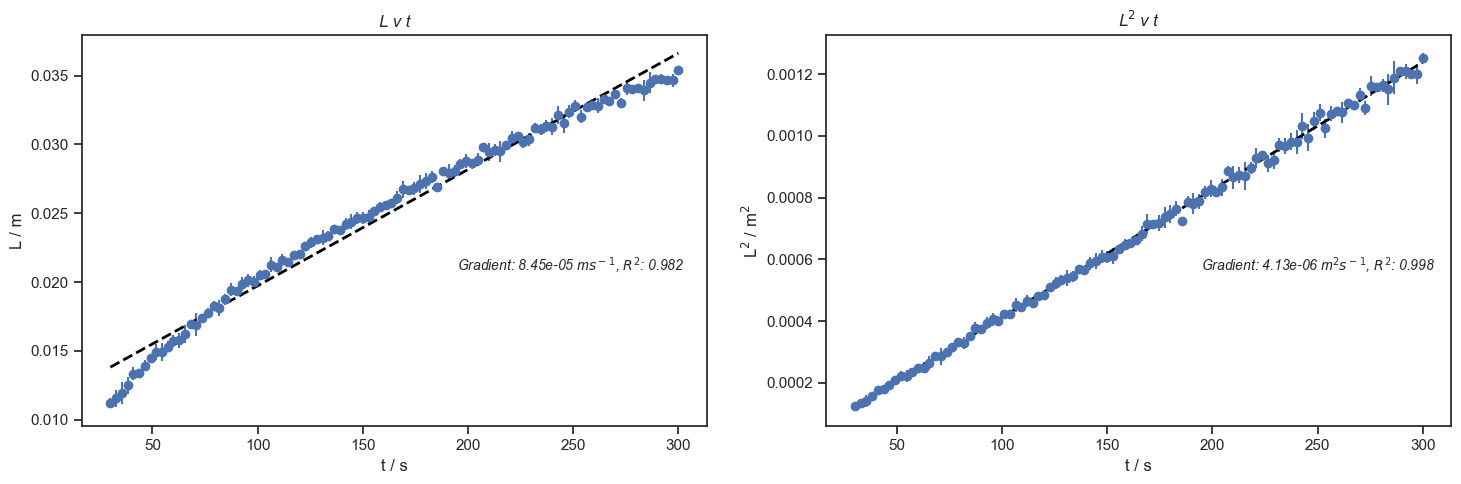

In [97]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
sns.set_theme(style='ticks', font='Arial')

# plotting L against t for entire time period
sns.scatterplot(data=tr3, x='t', y='L', ax=axes[0])
axes[0].errorbar(tr3['t'], tr3['L'], yerr=tr3['dL'], fmt='o', label='TR-3', c='b')

# adding line of best fit and determining gradient
m, c = np.polyfit(tr3['t'], tr3['L'], 1)
axes[0].plot(tr3['t'], m*tr3['t'] + c, color='black', linewidth=2, linestyle='--')

# determining R^2
residuals = tr3['L'] - (m*tr3['t'] + c)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((tr3['L'] - np.mean(tr3['L']))**2)
r_squared = 1 - (ss_res / ss_tot)

axes[0].text(0.6, 0.4, f'Gradient: {m:.3g} m$s^-$$^1$, $R^2$: {r_squared:.3f}', transform=axes[0].transAxes, fontsize=10, fontstyle='italic')
axes[0].set_title('L v t', fontstyle='italic')
axes[0].set_ylabel('L / m')


# plotting L^2 against t, adding error bars (dL)
tr3['L^2'] = tr3['L']**2
sns.scatterplot(data=tr3, x='t', y='L^2', ax=axes[1])
axes[1].errorbar(tr3['t'], tr3['L^2'], yerr=2*tr3['L']*tr3['dL'], fmt='o', label='TR-3', c='b')

m, c = np.polyfit(tr3['t'], tr3['L^2'], 1)
axes[1].plot(tr3['t'], m*tr3['t'] + c, color='black', linewidth=2, linestyle='--')
digestive_rate = m

residuals = tr3['L^2'] - (m*tr3['t'] + c)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((tr3['L^2'] - np.mean(tr3['L^2']))**2)
r_squared = 1 - (ss_res / ss_tot)

axes[1].text(0.6, 0.4, f'Gradient: {m:.3g} m$^2$$s^-$$^1$, $R^2$: {r_squared:.3f}', transform=axes[1].transAxes, fontsize=10, fontstyle='italic')
axes[1].set_title('L$^2$ v t', fontstyle='italic')
axes[1].set_ylabel('L$^2$ / m$^2$')


for ax in axes:
    ax.set_xlabel('t / s')

# fig.suptitle('Exploring Washburn Relationship between L and t (Digestive)', y=0.95)
fig.tight_layout()

##### **Findings & Comparison of Rates**

The results show that the digestive has the greatest rate of change, and so tea is reaching further in this biscuit type. This is followed by hobnob, and then rich tea. This is the same relationship as for the pore radii values, hence suggesting a high correlation between the two factors; a larger pore radius will absorb fluid more quickly than one that is smaller.

Both *L* vs *t* and *L<sup>2</sup>* vs t were plotted for all three biscuit types. In all cases, the latter produced a better fit (determined by R<sup>2</sup> values), and hence the relationship stated by the Washburn equation is correct in this investigation. However, the capabilities of the equation is explored further later.

To find a rate of capillary flow in each biscuit, the gradients of the line of best fits are considered. The *L<sup>2</sup>* vs *t* plot has a much better linear fit, and so this value is quoted going forward. The equivalent obtained by the *L* vs *t*, in potentially more understandable units, is compared; given their still very high correlation coefficients (0.98), these are reasonable approximations for capillary rate. These values, along with the associated pore radii, are quoted in the table below.

| *Biscuit Type* | *Microscopy determined pore radius (m)* | *Capillary Flow Rate (m<sup>2</sup>s<sup>-1</sup>)* | *L<sup>2</sup> R<sup>2</sup>* | *Capillary Flow Rate(ms<sup>-1</sup>)* | *L R<sup>2</sup>* |
|--------------|---------------|---------------|---------------|---------------|---------------|
| Hobnob       | 8.04 x 10<sup>-7</sup>        | 2.13 x 10<sup>-6</sup>        | 0.998       | 6.06 x 10<sup>-5</sup>        | 0.981        |
| Rich Tea     | 3.02 x 10<sup>-7</sup>        | 1.15 x 10<sup>-6</sup>        | 0.998       | 4.44 x 10<sup>-5</sup>        | 0.981        |
| Digestive    | 5.10 x 10<sup>-7</sup>        | 4.13 x 10<sup>-6</sup>        | 0.998       | 8.45 x 10<sup>-5</sup>        | 0.982        |

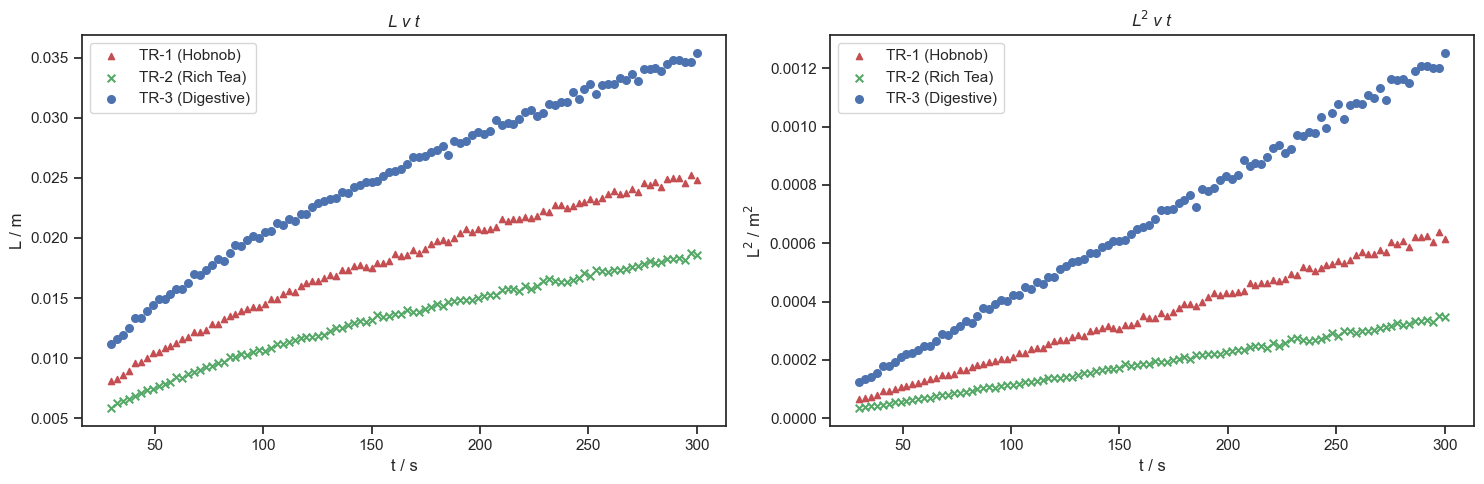

In [98]:
# plotting L against t
fig, axes = plt.subplots(1,2,figsize=(15, 5))
sns.set_theme(style='ticks', font='Arial')

# all data
axes[0].scatter(tr1['t'], tr1['L'], c='r', marker='^', label='tr-1', s=20)
axes[0].scatter(tr2['t'], tr2['L'], c='g', marker='x', label='tr-2', s=30)
axes[0].scatter(tr3['t'], tr3['L'], c='b', marker='o', label='tr-3', s=30)

axes[0].set_title('L v t', fontstyle='italic')
axes[0].set_ylabel('L / m')

# only L^2
axes[1].scatter(tr1['t'], tr1['L^2'], c='r', marker='^', label='tr-1', s=20)
axes[1].scatter(tr2['t'], tr2['L^2'], c='g', marker='x', label='tr-2', s=30)
axes[1].scatter(tr3['t'], tr3['L^2'], c='b', marker='o', label='tr-3', s=30)

axes[1].set_title('L$^2$ v t', fontstyle='italic')
axes[1].set_ylabel('L$^2$ / m$^2$')


# changing legend labels to show biscuit type
handles, labels = axes[0].get_legend_handles_labels()
custom_labels = {
    'tr-1': 'TR-1 (Hobnob)',
    'tr-2': 'TR-2 (Rich Tea)',
    'tr-3': 'TR-3 (Digestive)'
}

legend_labels = [custom_labels[label] if label in custom_labels else label for label in labels]
axes[0].legend(handles=handles, labels=legend_labels)
axes[1].legend(handles=handles, labels=legend_labels)

for ax in axes:
    ax.set_xlabel('t / s')

# fig.suptitle('Comparison of L vs t for Each Dataset', y=0.95)
fig.tight_layout()

The above plot visualises more clearly the difference in rate between the three biscuit categories. It is clear that the digestive has the highest capillary rate, and the rich tea the lowest, indicating a strong correlation with pore radius. This is demonstrated further in the plot below.

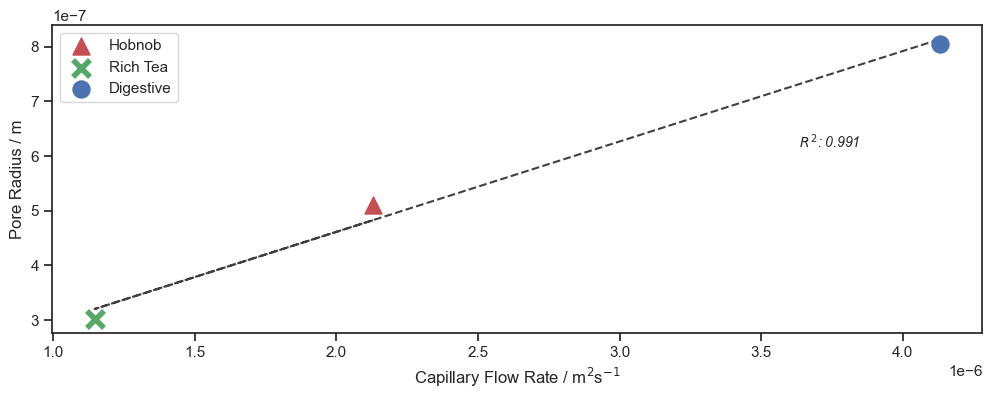

In [100]:
# plotting the relationship between pore radius and capillary flow rate
fig, ax = plt.subplots(figsize=(12, 4))
sns.set_theme(style='ticks', font='Arial')

ax.scatter(hobnob_rate, hobnob_r, label='Hobnob', color='r', marker='^', s=150)
ax.scatter(rich_tea_rate, rich_tea_r, label='Rich Tea', color='g', marker='x', s=150, linewidth=4)    
ax.scatter(digestive_rate, digestive_r, label='Digestive', color='b', marker='o', s=150)

# line of best fit
m, c = np.polyfit([hobnob_rate, rich_tea_rate, digestive_rate], [hobnob_r, rich_tea_r, digestive_r], 1)
ax.plot([hobnob_rate, rich_tea_rate, digestive_rate], m*np.array([hobnob_rate, rich_tea_rate, digestive_rate]) + c, 
        color='black', linestyle='--', alpha=0.75, zorder=0)

# adding R^2 value
residuals = [hobnob_r, rich_tea_r, digestive_r] - (m*np.array([hobnob_rate, rich_tea_rate, digestive_rate]) + c)
ss_res = np.sum(residuals**2)
ss_tot = np.sum(([hobnob_r, rich_tea_r, digestive_r] - np.mean([hobnob_r, rich_tea_r, digestive_r]))**2)
r_squared = 1 - (ss_res / ss_tot)

ax.text(0.8, 0.6, f' $R^2$: {r_squared:.3f}', transform=ax.transAxes, fontsize=10, fontstyle='italic')

ax.set_xlabel('Capillary Flow Rate / m$^2$s$^{-1}$')
ax.set_ylabel('Pore Radius / m')
ax.legend()

### *Further Exploration of The Washburn Equation*

The previous determination of *r* using the Washburn equation demonstrated some potential limitations; there was a 20.3% difference between that calculated by the equation and the microscopy data for the digestive. Therefore, the equation is explored in more detail here. It has already been shown, however, that the expected Washburn relationship (L<sup>2</sup> ∝ t) between *L* and *t* is very applicable here, indicating a high suitability. 

Two experiments are outlined below. In the first case, values calculated by the Washburn equation are simply compared to a ground truth. The second experiment uses the time-resolved datasets to explore the performance of the equation over time, comparing to the presumed average *r* determined earlier.

##### **Comparison to Known Value - Microscopy Data**

In [101]:
microscopy_df['predicted_L'] = np.sqrt((microscopy_df['r'] * microscopy_df['gamma'] * microscopy_df['t'] * np.cos(microscopy_df['phi']))/(2*microscopy_df['eta']))
microscopy_df['predicted_r'] = (microscopy_df['L']**2 * 2*microscopy_df['eta'])/(microscopy_df['gamma']*microscopy_df['t']*np.cos(microscopy_df['phi']))

microscopy_df.head()

,gamma,phi,eta,L,t,r,gbt_classification,kmeans_labels,predicted_L,predicted_r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07,Digestive,0,0.003233,7.396247e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07,Rich Tea,1,0.002436,2.513107e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07,Digestive,0,0.001251,7.678998e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07,Digestive,0,0.000567,8.494983e-07
5,0.085412,1.360402,0.000989,0.009751,21.397341,5.018350e-07,Hobnob,2,0.009839,4.928153e-07


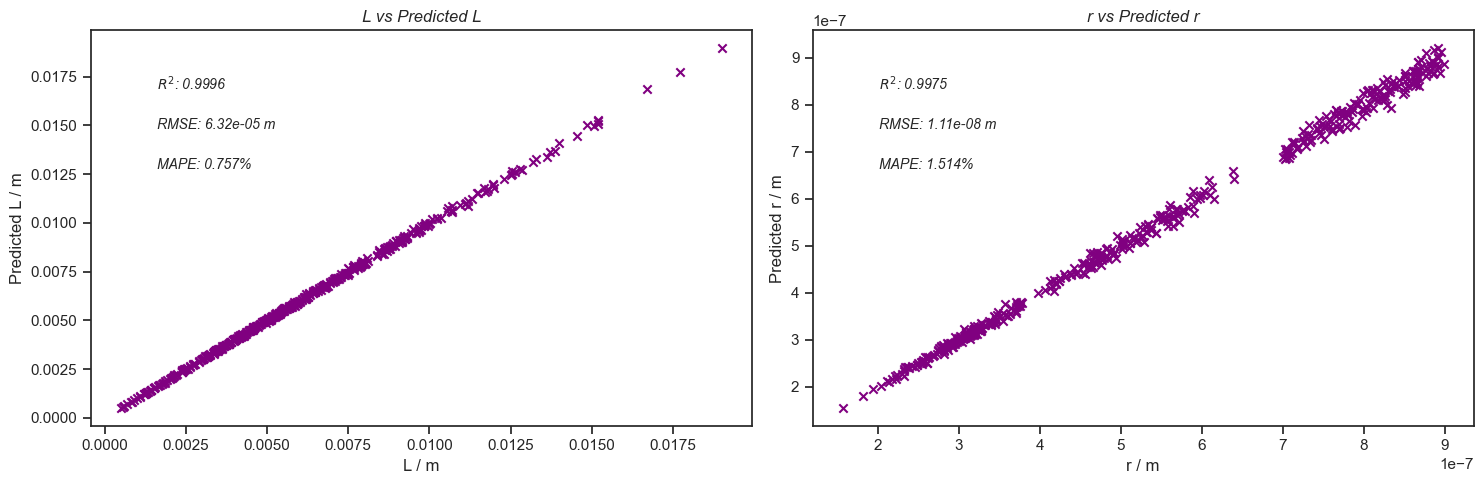

In [102]:
# plotting given values against predicted values
fig, axes = plt.subplots(1,2,figsize=(15, 5))
sns.set_theme(style='ticks', font='Arial')

# L
axes[0].scatter(microscopy_df['L'], microscopy_df['predicted_L'], c='purple', marker='x')

axes[0].set_xlabel('L / m')
axes[0].set_ylabel('Predicted L / m')
axes[0].set_title('L vs Predicted L', fontstyle='italic')

# calculating R^2, RMSE and MAPE values and adding to plot
r2 = r2_score(microscopy_df['L'], microscopy_df['predicted_L'])
rmse = np.sqrt(mean_squared_error(microscopy_df['L'], microscopy_df['predicted_L']))
mape = np.mean(np.abs((microscopy_df['L'] - microscopy_df['predicted_L']) / microscopy_df['L'])) * 100

axes[0].text(0.1, 0.85, f'$R^2$: {r2:.4f}', transform=axes[0].transAxes, fontsize=10, fontstyle='italic')
axes[0].text(0.1, 0.75, f'RMSE: {rmse:.3g} m', transform=axes[0].transAxes, fontsize=10, fontstyle='italic')
axes[0].text(0.1, 0.65, f'MAPE: {mape:.3f}%', transform=axes[0].transAxes, fontsize=10, fontstyle='italic')


# r
axes[1].scatter(microscopy_df['r'], microscopy_df['predicted_r'], c='purple', marker='x')

axes[1].set_xlabel('r / m')
axes[1].set_ylabel('Predicted r / m')    
axes[1].set_title('r vs Predicted r', fontstyle='italic')

# calculating R^2, RMSE and MAPE values and adding to plot
r2 = r2_score(microscopy_df['r'], microscopy_df['predicted_r'])
rmse = np.sqrt(mean_squared_error(microscopy_df['r'], microscopy_df['predicted_r']))
mape = np.mean(np.abs((microscopy_df['r'] - microscopy_df['predicted_r']) / microscopy_df['r'])) * 100

axes[1].text(0.1, 0.85, f'$R^2$: {r2:.4f}', transform=axes[1].transAxes, fontsize=10, fontstyle='italic')
axes[1].text(0.1, 0.75, f'RMSE: {rmse:.3g} m', transform=axes[1].transAxes, fontsize=10, fontstyle='italic')
axes[1].text(0.1, 0.65, f'MAPE: {mape:.3f}%', transform=axes[1].transAxes, fontsize=10, fontstyle='italic')


# fig.suptitle('Comparison of Washburn Predicted Values to True Values', y=0.95)
fig.tight_layout()

These plots show the Washburn equation to be very good. For *L*, the predicted values almost perfectly correlate with the given truth, and produced a percentage error of only 0.761% across the 500 datapoints. For *r*, there is some visual deviation at larger radii. However, there is still a very high correlation coefficient and a percentage error of only 1.523%. The calculated statistics are summarised below.

| *Metric*                                | *Distance travelled by tea up biscuit, L (m)* | *Pore Radius, r (m)*     |
|--------------                           |---------------                                |---------------           |
| Correlation Coefficient, R<sup>2</sup>  | 0.9996                                        | 0.9974                   |
| Root mean squared error, RMSE           | 6.43 x 10 <sup>-5</sup>                       | 6.43 x 10 <sup>-5</sup>  | 
| Mean absolute percentage error, MAPE    | 0.761%                                        | 1.523%                   |

##### **Exploration of Performance Over Time - Time-Resolved Data**

To explore performance over time, the time-resolved datasets are used. Pore radius values determined through the use of the Washburn equation are plotted against time, and the microscopy established value is shown. For the rich tea and the digestive, the upper and lower range values are used, as they align more closely with the microscopy data.

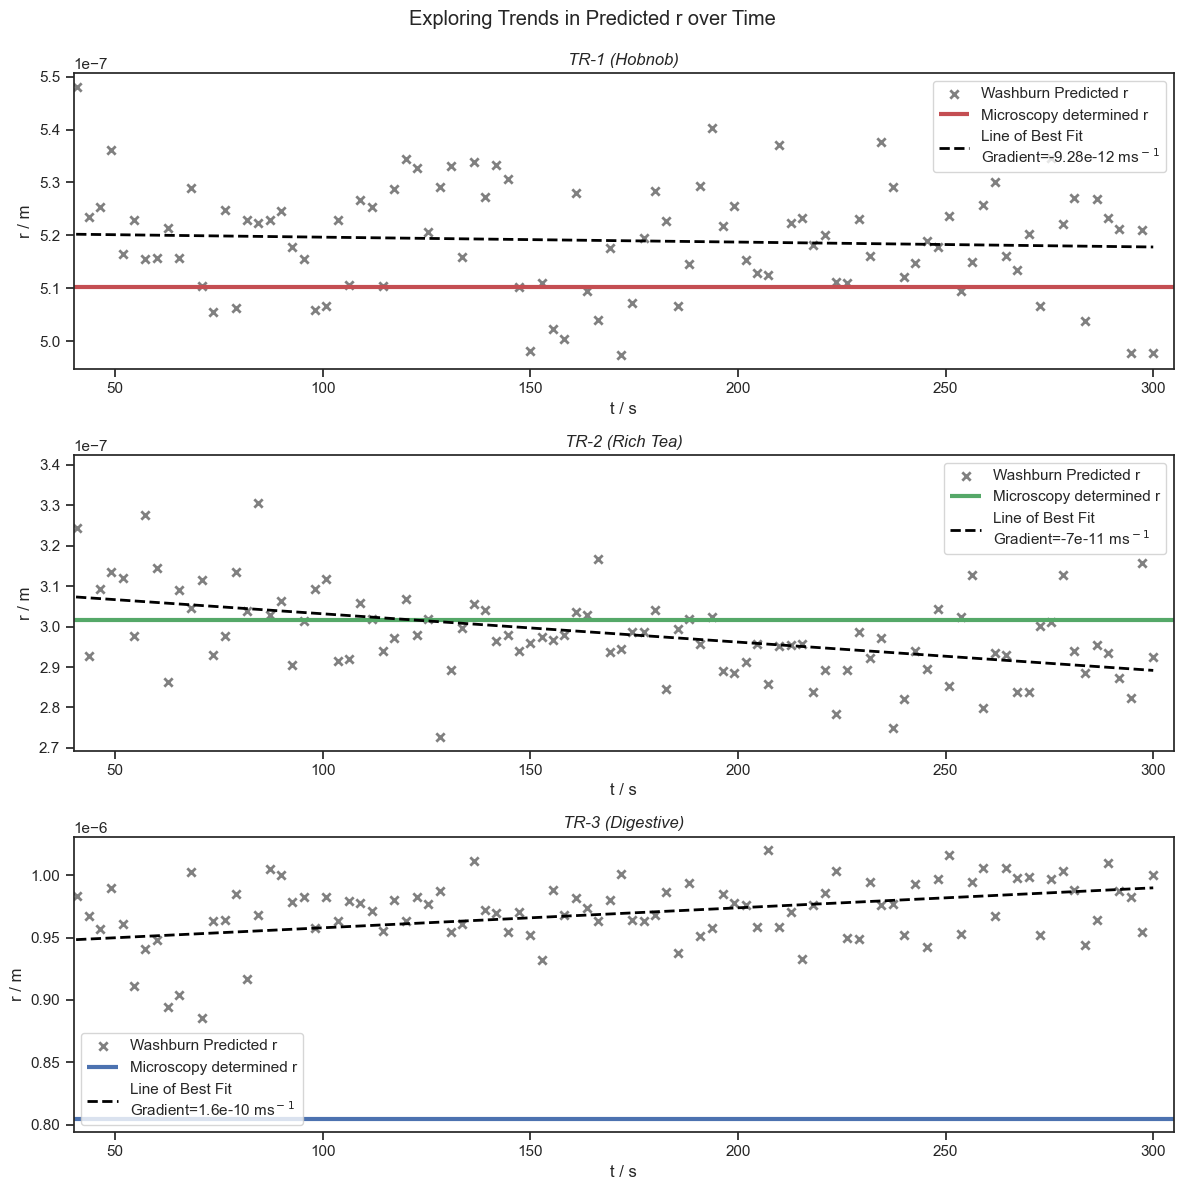

In [112]:
# plotting t against r
fig, axes = plt.subplots(3,1,figsize=(12, 12))
sns.set_theme(style='ticks', font='Arial')

# tr1 - hobnob
sns.scatterplot(data=tr1, x='t', y='predicted_r', ax=axes[0], marker='x', linewidth=2, color='grey', label='Washburn Predicted r')
axes[0].hlines(hobnob_r, 0, 400, color='r', linestyle='-', label='Microscopy determined r', linewidth=3)
axes[0].set_xlim(40,305)
axes[0].set_title('TR-1 (Hobnob)', fontstyle='italic')

m, c = np.polyfit(tr1['t'], tr1['predicted_r'], 1)
axes[0].plot(tr1['t'], m*tr1['t'] + c, color='black', linewidth=2, linestyle='--', label=f'Line of Best Fit \nGradient={m:.3g} ms$^-$$^1$')


# tr2 - rich tea
sns.scatterplot(data=tr2, x='t', y='predicted_r_maxL', ax=axes[1], marker='x', linewidth=2, color='grey', label='Washburn Predicted r')
axes[1].hlines(rich_tea_r, 0, 400, color='g', linestyle='-', label='Microscopy determined r', linewidth=3)
axes[1].set_xlim(40,305)
axes[1].set_title('TR-2 (Rich Tea)', fontstyle='italic')

m, c = np.polyfit(tr2['t'], tr2['predicted_r_maxL'], 1)
axes[1].plot(tr2['t'], m*tr2['t'] + c, color='black', linewidth=2, linestyle='--', label=f'Line of Best Fit \nGradient={m:.3g} ms$^-$$^1$')


# tr3 - digestive
sns.scatterplot(data=tr3, x='t', y='predicted_r_minL', ax=axes[2], marker='x', linewidth=2, color='grey', label='Washburn Predicted r')
axes[2].hlines(digestive_r, 0, 400, color='b', linestyle='-', label='Microscopy determined r', linewidth=3)
axes[2].set_xlim(40,305)
axes[2].set_title('TR-3 (Digestive)', fontstyle='italic')

m, c = np.polyfit(tr3['t'], tr3['predicted_r_minL'], 1)
axes[2].plot(tr3['t'], m*tr3['t'] + c, color='black', linewidth=2, linestyle='--', label=f'Line of Best Fit \nGradient={m:.3g} ms$^-$$^1$')


for ax in axes:
    ax.legend()
    ax.set_xlabel('t / s')
    ax.set_ylabel('r / m')

fig.suptitle('Exploring Trends in Predicted r over Time', y=0.99)
fig.tight_layout()

These results show that the Washburn equation is seemingly robust over time. In the case of the hobnob, the trend is changing very little, and if anything is getting closer to the "true" value determined from microscopy. However, the rich tea and digestives are showing to be getting further from the true value as time increases; rich tea is decreasing, but digestive is increasing. Given how effective Washburn has shown to be up to this point, it can be assumed that this change is as a result of external factors. Constants were given for the tea surface tension, dynamic viscoscity and contact angle; these may change over time as the tea is absorbed further and the biscuit likely begins to break down/dissolve. Therefore, the observed difference is likely as a result on inconsistencies in one of these variables, rather than limitations of the Washburn equation.

These experiments suggest that the Washburn is robust and so not contributing to the observed difference in pore radii values for the digestive. There must, therefore, be other factors having an impact, such as inaccuracies in the reported surface tension or viscosity.

### *Using a Machine Learning Regressor to Compete with the Washburn Equation*

The Washburn equation has been shown to be effective in this application, even when testing over a large time period. However, many variables must be calculated for this equation, many of which can be hard to do (such as the surface tension of the tea). With measurements of this type, human error can lead to significant drops in accuracy. Therefore, this final section will explore using a machine learning regression algorithm to predict *L* with a similar accuracy to Washburn, while limiting the number of variables used and hence decrease the impact of human and instrumentation error.

#### Considering All Variables

First, all variables will be used to create a regression model. Again, different types are tested and the best chosen. The most importance features will be identified and therefore used for the reduced variable model.

In [113]:
# fitting a regression algorithm on microscopy data to predict L
X_microscopy_regressor = microscopy_df.drop(columns=['L', 'predicted_L', 'predicted_r', 'gbt_classification', 'kmeans_labels'])
y_microscopy_regressor = microscopy_df['L']

# splitting into training and testing data - 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_microscopy_regressor, y_microscopy_regressor, test_size=0.25, random_state=42)

# splitting testing data further into testing and validation data - 18% testing, 12% validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4, random_state=42)

##### **Random Forest Regressor**

In [114]:
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

# predicting L values using the random forest regressor
y_pred_rf = rf_regressor.predict(X_test)

# evaluating the model using R^2, RMSE and MAPE
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print(f'R^2: {r2_rf:.3g}')
print(f'RMSE: {rmse_rf:.3g} m')
print(f'MAPE: {mape_rf:.3g}%')

R^2: 0.932
RMSE: 0.000763 m
MAPE: 8.49%


##### **Gradient Boosted Regressor**

In [115]:
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train, y_train)

y_pred_gb = gb_regressor.predict(X_test)

r2_gb = r2_score(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mape_gb = np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100

print(f'R^2: {r2_gb:.3g}')
print(f'RMSE: {rmse_gb:.3g} m')
print(f'MAPE: {mape_gb:.3g}%')

R^2: 0.842
RMSE: 0.00116 m
MAPE: 14.9%


##### **Multiple Linear Regression**

In [116]:
mlr_regressor = LinearRegression()
mlr_regressor.fit(X_train, y_train)

y_pred_mlr = mlr_regressor.predict(X_test)

r2_mlr = r2_score(y_test, y_pred_mlr)
rmse_mlr = np.sqrt(mean_squared_error(y_test, y_pred_mlr))
mape_mlr = np.mean(np.abs((y_test - y_pred_mlr) / y_test)) * 100

print(f'R^2: {r2_mlr:.3g}')
print(f'RMSE: {rmse_mlr:.3g} m')
print(f'MAPE: {mape_mlr:.3g}%')

R^2: 0.893
RMSE: 0.000956 m
MAPE: 15.5%


##### **Comparison of Regressors**

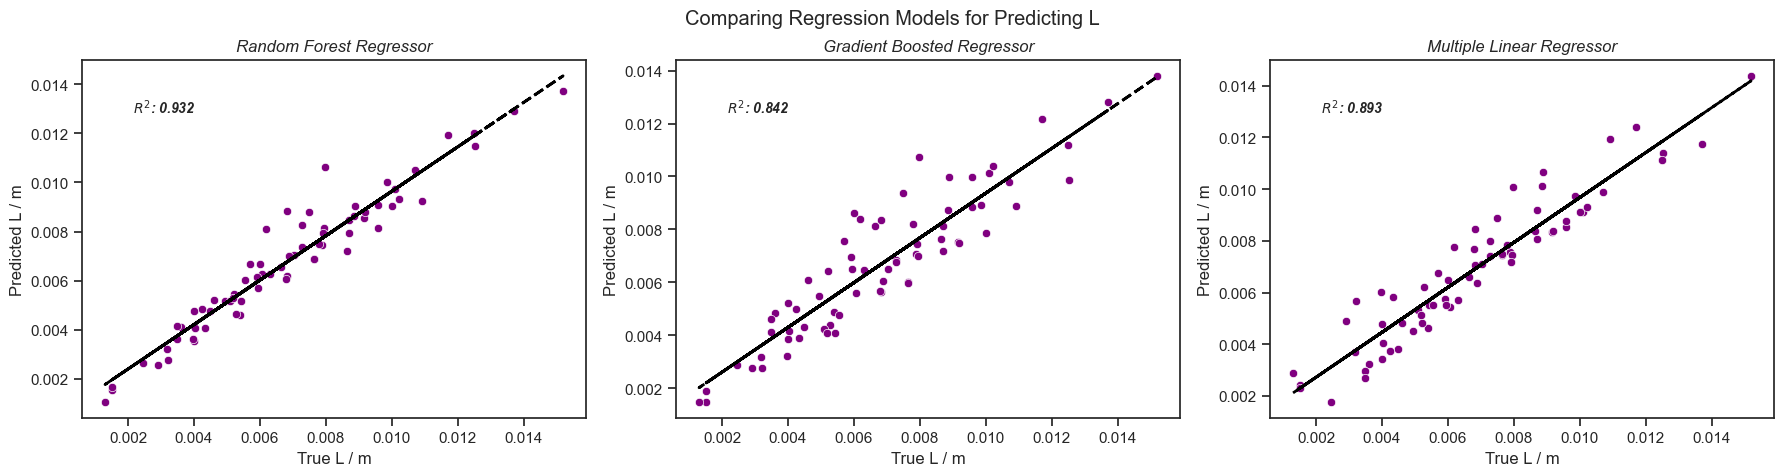

In [117]:
# plotting predicted L values against true L values
fig, axes = plt.subplots(1,3,figsize=(18, 5))
sns.set_theme(style='ticks', font='Arial')

# random forest regressor
sns.scatterplot(x=y_test, y=y_pred_rf, ax=axes[0], color='purple')
axes[0].set_xlabel('True L / m')
axes[0].set_ylabel('Predicted L / m')
axes[0].set_title('Random Forest Regressor', fontstyle='italic')

m, c = np.polyfit(y_test, y_pred_rf, 1)
axes[0].plot(y_test, m*y_test + c, color='black', linewidth=2, linestyle='--')
axes[0].text(0.1, 0.85, f'$R^2$: {r2_rf:.3f}', transform=axes[0].transAxes, fontsize=10, fontstyle='italic', fontweight='bold')

# gradient boosted regressor
sns.scatterplot(x=y_test, y=y_pred_gb, ax=axes[1], color='purple')
axes[1].set_xlabel('True L / m')
axes[1].set_ylabel('Predicted L / m')
axes[1].set_title('Gradient Boosted Regressor', fontstyle='italic')

m, c = np.polyfit(y_test, y_pred_gb, 1)
axes[1].plot(y_test, m*y_test + c, color='black', linewidth=2, linestyle='--')
axes[1].text(0.1, 0.85, f'$R^2$: {r2_gb:.3f}', transform=axes[1].transAxes, fontsize=10, fontstyle='italic', fontweight='bold')

# multiple linear regression
sns.scatterplot(x=y_test, y=y_pred_mlr, ax=axes[2], color='purple')
axes[2].set_xlabel('True L / m')
axes[2].set_ylabel('Predicted L / m')
axes[2].set_title('Multiple Linear Regressor', fontstyle='italic')

m, c = np.polyfit(y_test, y_pred_mlr, 1)
axes[2].plot(y_test, m*y_test + c, color='black', linewidth=2, linestyle='--')
axes[2].text(0.1, 0.85, f'$R^2$: {r2_mlr:.3f}', transform=axes[2].transAxes, fontsize=10, fontstyle='italic', fontweight='bold')


fig.suptitle('Comparing Regression Models for Predicting L', y=0.95)
fig.tight_layout()

The model with all parameters has shown to be effective, even prior to model optimisation. This indicates that a regressor can indeed be applied to this problem with reasonable results. The three choices all show potential, but the choice is made to use the random forest regressor going forward.

##### **Random Forest Regressor Feature Importance**

Text(0.5, 1.0, 'Feature Importance for Predicting L')

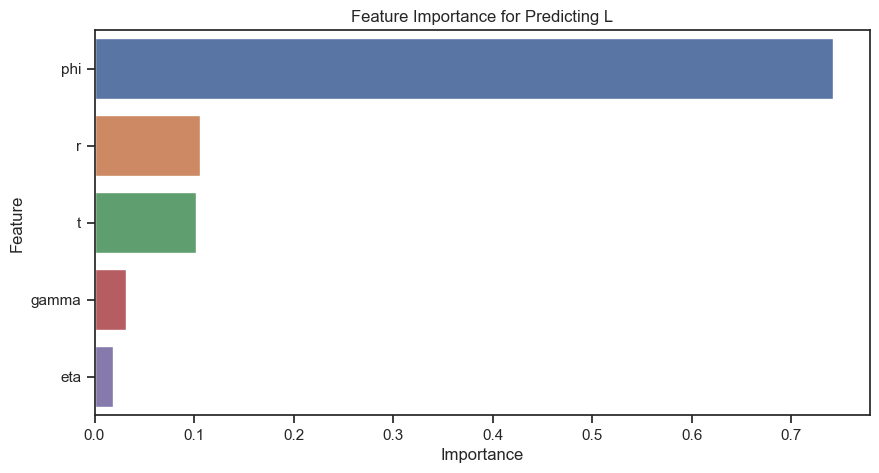

In [118]:
# feature importance
feature_importance = rf_regressor.feature_importances_
feature_names = X_microscopy_regressor.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style='ticks', font='Arial')

sns.barplot(data=feature_importance_df, x='Importance', y='Feature', ax=ax, palette='deep', hue='Feature')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance for Predicting L')

Exploring feature importance shows that *phi* is the most important factors for the random forest regressor by a significant margin. This is followed by *t*, which is closely followed by *r*. The variables obtained from the tea are seemingly much less important.

*phi*, *t* and *r* will be considered for the reduced parameter model. This considers the most important factor, as well as additional biscuit parameters that are relatively easy to measure and add additional information. Whilst *r* is not necessarily easy to measure, once a value is established for a given biscuit type, this should be relatively consistent across biscuits, given their same ingredients and manufacture process.

##### **Reduced Variable Model - considering biscuit features only**

In [119]:
# fitting a regression algorithm on microscopy data to predict L using a reduced number of variables
X_reduced = microscopy_df[['phi', 't', 'r']]
y_reduced = microscopy_df['L']

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4, random_state=42)

In [120]:
# initial fitting of regressor
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

# predicting L values using the random forest regressor
y_pred = rf_regressor.predict(X_test)

# evaluating the model using R^2, RMSE and MAPE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'R^2: {r2:.3g}')
print(f'RMSE: {rmse:.3g} m')
print(f'MAPE: {mape:.3g}%')

R^2: 0.928
RMSE: 0.000789 m
MAPE: 8.5%


In [121]:
# optimising regressor with validation set - aiming to reduce MAPE
rf_regressor_optimised = RandomForestRegressor(random_state=42, n_estimators=250, max_depth=20, min_samples_split=2,
                                               criterion='poisson', min_samples_leaf=1, bootstrap=True)

rf_regressor_optimised.fit(X_train, y_train)


y_pred_optimised = rf_regressor_optimised.predict(X_val)

r2_optimised = r2_score(y_val, y_pred_optimised)
rmse_optimised = np.sqrt(mean_squared_error(y_val, y_pred_optimised))
mape_optimsed = np.mean(np.abs((y_val - y_pred_optimised) / y_val)) * 100

print(f'R^2: {r2_optimised:.3g}')
print(f'RMSE: {rmse_optimised:.3g} m')
print(f'MAPE: {mape_optimsed:.5g}%')

R^2: 0.895
RMSE: 0.00103 m
MAPE: 12.755%


In [122]:
# evaluating on test set
y_pred_final = rf_regressor_optimised.predict(X_test)

r2_final = r2_score(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mape_final = np.mean(np.abs((y_test - y_pred_final) / y_test)) * 100

print(f'R^2: {r2_final:.3g}')
print(f'RMSE: {rmse_final:.3g} m')
print(f'MAPE: {mape_final:.3g}%')

R^2: 0.929
RMSE: 0.000781 m
MAPE: 8.43%


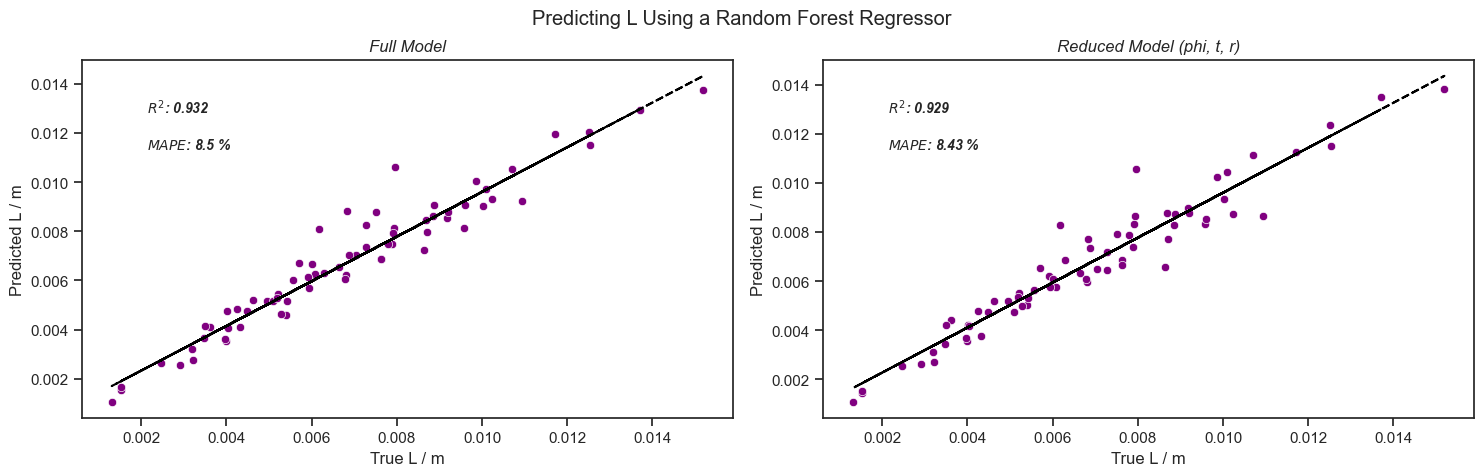

In [123]:
# plotting predicted L values against true L values - comparing reduced model to full model
fig, axes = plt.subplots(1,2,figsize=(15, 5))
sns.set_theme(style='ticks', font='Arial')

# full model
sns.scatterplot(x=y_test, y=y_pred_rf, ax=axes[0], c='purple')
axes[0].set_xlabel('True L / m')
axes[0].set_ylabel('Predicted L / m')
axes[0].set_title('Full Model', fontstyle='italic')

m, c = np.polyfit(y_test, y_pred, 1)
axes[0].plot(y_test, m*y_test + c, color='black', linestyle='--', label=f'Line of Best Fit \nGradient={m:.3g}')
axes[0].text(0.1, 0.85, f'$R^2$: {r2_rf:.3f}', transform=axes[0].transAxes, fontsize=10, fontstyle='italic', fontweight='bold')
axes[0].text(0.1, 0.75, f'$MAPE$: {mape_rf:.1f} %', transform=axes[0].transAxes, fontsize=10, fontstyle='italic', fontweight='bold')

# reduced model
sns.scatterplot(x=y_test, y=y_pred_final, ax=axes[1], c='purple')
axes[1].set_xlabel('True L / m')
axes[1].set_ylabel('Predicted L / m')
axes[1].set_title('Reduced Model (phi, t, r)', fontstyle='italic')

m, c = np.polyfit(y_test, y_pred_final, 1)
axes[1].plot(y_test, m*y_test + c, color='black', linestyle='--', label=f'Line of Best Fit \nGradient={m:.3g}')
axes[1].text(0.1, 0.85, f'$R^2$: {r2_final:.3f}', transform=axes[1].transAxes, fontsize=10, fontstyle='italic', fontweight='bold')
axes[1].text(0.1, 0.75, f'$MAPE$: {mape_final:.2f} %', transform=axes[1].transAxes, fontsize=10, fontstyle='italic', fontweight='bold')

fig.suptitle('Predicting L Using a Random Forest Regressor', y=0.95)
fig.tight_layout()

These results show that a machine learning regressor can indeed be an effective substitute for the Washburn equation. It offers a faster outcome and can recreate results when using fewer predictors, hence reducing the measurements required and the chance of human/instrumentation error causing anomalies.

The reduced model considers only values that are obtained from the biscuit, which are arguably easier to obtain that the surface tension and dynamic viscosity of the tea. *phi* was shown to be a very important feature in predicting *L* values, whilst *t* and *r* offer an more information into biscuit type and conditions to which the biscuit is exposed. The reduced model achieved a correlation coefficient of 0.929, showing a very close relationship with the true values. These results were comparable to the full model, and even saw a slight decrease in average percentage error (8.50% to 8.43%).